Identification Rate Metric

Так как  ни query, ни distractors не должны содержать людей из train/val, будем использовать предобработанный test. В работе я взяла на себя смелость обозначить TPR@FPR как TAR@FAR. Кроме того, verification (пороговая метрика TAR@FAR) и identification как ranking metric (IR@k) посчитаны с учетом уже готовых embeddings и labels.

In [5]:
from __future__ import annotations

import os
import json
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torchvision.models as models
from IPython.display import display
import matplotlib.pyplot as plt

In [6]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
CSV_DIR = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact")
train_csv = CSV_DIR / "train_recognition_112.csv"
val_csv   = CSV_DIR / "val_recognition_112.csv"
test_csv  = CSV_DIR / "test_recognition_112.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Веса
ARC_CKPT = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt")
CE_CKPT  = Path("/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_last_700.pt")

# CSV columns
ID_COL    = "image_id"
PATH_COL  = "aligned_path"
LABEL_COL = "label"

IMG_SIZE = 112
BATCH_SIZE = 128
NUM_WORKERS = 2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [8]:

# Models
class ResNet34FaceCEIdeal(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                w = old_conv.weight
                new_conv.weight.copy_(w[:, :, 2:5, 2:5])
        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        in_features = m.fc.in_features
        m.fc = nn.Identity()

        self.backbone = m
        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),  # bias=False!
            nn.BatchNorm1d(emb_dim),
        )
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)
        emb = self.emb(feat)
        logits = self.classifier(emb)
        return logits

class ResNet34FaceArc(nn.Module):
    def __init__(self, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        m = models.resnet34(weights=weights)

        old_conv = m.conv1
        new_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                w = old_conv.weight
                new_conv.weight.copy_(w[:, :, 2:5, 2:5])

        m.conv1 = new_conv
        m.maxpool = nn.Identity()

        in_features = m.fc.in_features
        m.fc = nn.Identity()

        self.backbone = m
        self.emb = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=False),  # <-- ВАЖНО: bias=False
            nn.BatchNorm1d(emb_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat = self.backbone(x)
        emb = self.emb(feat)
        return emb
 # embedding (B,512)


In [9]:
# Dataset + transforms (aligned 112)
def read_image_rgb(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def to_tensor_norm(img: Image.Image) -> torch.Tensor:
    x = torch.from_numpy(np.array(img)).permute(2,0,1).float() / 255.0
    # как обычно в твоих ноутбуках: (x-0.5)/0.5 => [-1,1]
    x = (x - 0.5) / 0.5
    return x

class FaceIDAlignedDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row[PATH_COL]
        y = int(row[LABEL_COL])

        img = read_image_rgb(path)
        if img.size != (IMG_SIZE, IMG_SIZE):
            img = img.resize((IMG_SIZE, IMG_SIZE))
        x = to_tensor_norm(img)
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(csv_path: Path, batch_size=BATCH_SIZE, shuffle=False):
    df = pd.read_csv(csv_path)
    ds = FaceIDAlignedDataset(df)
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE.type == "cuda"),
        drop_last=False,
    )
    return df, dl


In [10]:
# Dataset + transforms (aligned 112)
def read_image_rgb(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def to_tensor_norm(img: Image.Image) -> torch.Tensor:
    x = torch.from_numpy(np.array(img)).permute(2,0,1).float() / 255.0
    # как обычно у меня везде (x-0.5)/0.5 => [-1,1]
    x = (x - 0.5) / 0.5
    return x

class FaceIDAlignedDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row[PATH_COL]
        y = int(row[LABEL_COL])

        img = read_image_rgb(path)
        if img.size != (IMG_SIZE, IMG_SIZE):
            img = img.resize((IMG_SIZE, IMG_SIZE))
        x = to_tensor_norm(img)
        return x, torch.tensor(y, dtype=torch.long)

def make_loader(csv_path: Path, batch_size=BATCH_SIZE, shuffle=False):
    df = pd.read_csv(csv_path)
    ds = FaceIDAlignedDataset(df)
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=(DEVICE.type == "cuda"),
        drop_last=False,
    )
    return df, dl


In [11]:
# ) Data sanity по 3 CSV из splits_compact
def sanity_check_df(df: pd.DataFrame, name: str, n_check: int = 200):
    print(f"\n--- {name} ---")
    print("rows:", len(df), "| cols:", list(df.columns))
    print("n_ids:", df[LABEL_COL].nunique())
    print("label min/max:", df[LABEL_COL].min(), df[LABEL_COL].max())
    print("null paths:", df[PATH_COL].isna().sum())

    # проверка существования файлов
    sample = df.sample(min(n_check, len(df)), random_state=SEED)
    missing = [p for p in sample[PATH_COL].tolist() if not os.path.exists(p)]
    print("missing (sampled):", len(missing))
    if len(missing) > 0:
        print("example missing:", missing[0])

    # проверка чтения/размера
    ok = 0
    for p in sample[PATH_COL].tolist()[:50]:
        try:
            img = read_image_rgb(p)
            if img.size == (IMG_SIZE, IMG_SIZE):
                ok += 1
        except Exception:
            pass
    print(f"read OK (first 50): {ok}/50 (size==112x112)")

# load
df_tr = pd.read_csv(train_csv)
df_va = pd.read_csv(val_csv)
df_te = pd.read_csv(test_csv)

sanity_check_df(df_tr, "TRAIN")
sanity_check_df(df_va, "VAL")
sanity_check_df(df_te, "TEST")

# 1 батч
_, dl_tr = make_loader(train_csv, shuffle=True)
xb, yb = next(iter(dl_tr))
print("\nBATCH:", xb.shape, yb.shape, xb.dtype, yb.dtype)



--- TRAIN ---
rows: 10070 | cols: ['image_id', 'aligned_path', 'label']
n_ids: 700
label min/max: 0 699
null paths: 0
missing (sampled): 0
read OK (first 50): 50/50 (size==112x112)

--- VAL ---
rows: 2518 | cols: ['image_id', 'aligned_path', 'label']
n_ids: 700
label min/max: 0 699
null paths: 0
missing (sampled): 0
read OK (first 50): 50/50 (size==112x112)

--- TEST ---
rows: 1399 | cols: ['image_id', 'aligned_path', 'label']
n_ids: 700
label min/max: 0 699
null paths: 0
missing (sampled): 0
read OK (first 50): 50/50 (size==112x112)

BATCH: torch.Size([128, 3, 112, 112]) torch.Size([128]) torch.float32 torch.int64


In [12]:
# Load checkpoints
def load_model_state(model: nn.Module, ckpt_path: Path, device=DEVICE):
    ckpt = torch.load(str(ckpt_path), map_location=device)
    sd = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
    # убираем module. если вдруг
    clean = {k.replace("module.", ""): v for k, v in sd.items()}
    model.load_state_dict(clean, strict=True)
    return ckpt

NUM_CLASSES = int(df_tr[LABEL_COL].nunique())


ce_model = ResNet34FaceCEIdeal(num_classes=NUM_CLASSES, emb_dim=512, pretrained=False).to(DEVICE)
ckpt_ce = load_model_state(ce_model, CE_CKPT, device=DEVICE)
ce_model.eval()
print("CE loaded:", CE_CKPT)

arc_model = ResNet34FaceArc(emb_dim=512, pretrained=False).to(DEVICE)
ckpt_arc = load_model_state(arc_model, ARC_CKPT, device=DEVICE)
arc_model.eval()
print("ArcFace loaded:", ARC_CKPT)



CE loaded: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/ce_last_700.pt
ArcFace loaded: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/checkpoints/arcface_best_fr.pt


In [13]:
# ArcFace: verification на test (thr по val)
def l2_normalize(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    return x / (x.norm(dim=1, keepdim=True) + eps)

@torch.no_grad()
def compute_embeddings(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    embs, labs = [], []
    for xb, yb in tqdm(loader, desc="Embeddings", leave=False):
        xb = xb.to(DEVICE, non_blocking=True)
        out = model(xb)
        out = l2_normalize(out)
        embs.append(out.cpu().numpy())
        labs.append(yb.numpy())
    return np.concatenate(embs, 0), np.concatenate(labs, 0)

def make_verif_pairs(labels: np.ndarray, n_pairs: int = 30000, seed: int = SEED):
    rng = np.random.default_rng(seed)
    labels = labels.astype(int)
    idx_by = {lab: np.where(labels == lab)[0] for lab in np.unique(labels)}
    labs = np.array(list(idx_by.keys()))

    pairs_i, pairs_j, ys = [], [], []
    half = n_pairs // 2

    # same
    for _ in range(half):
        lab = int(rng.choice(labs))
        idxs = idx_by[lab]
        if len(idxs) < 2:
            continue
        i, j = rng.choice(idxs, size=2, replace=False)
        pairs_i.append(int(i)); pairs_j.append(int(j)); ys.append(1)

    # diff
    for _ in range(half):
        lab1, lab2 = rng.choice(labs, size=2, replace=False)
        i = int(rng.choice(idx_by[int(lab1)]))
        j = int(rng.choice(idx_by[int(lab2)]))
        pairs_i.append(i); pairs_j.append(j); ys.append(0)

    return np.array(pairs_i), np.array(pairs_j), np.array(ys)

def cosine_scores(embs: np.ndarray, i: np.ndarray, j: np.ndarray) -> np.ndarray:
    return np.sum(embs[i] * embs[j], axis=1)

def find_best_thr(scores: np.ndarray, y_true: np.ndarray) -> Tuple[float, float]:
    uniq = np.unique(scores)
    # ускорение: не все пороги, а равномерная сетка по uniq
    step = max(1, len(uniq)//2000)
    best_thr, best_acc = 0.0, -1.0
    for thr in uniq[::step]:
        pred = (scores >= thr).astype(int)
        acc = float((pred == y_true).mean())
        if acc > best_acc:
            best_acc = acc
            best_thr = float(thr)
    return best_thr, best_acc

def tar_at_far(scores: np.ndarray, y_true: np.ndarray, far: float) -> float:
    neg = scores[y_true == 0]
    thr = float(np.quantile(neg, 1.0 - far))
    pos = scores[y_true == 1]
    return float((pos >= thr).mean())

# loaders
_, dl_val  = make_loader(val_csv, shuffle=False)
_, dl_test = make_loader(test_csv, shuffle=False)

# embeddings
val_embs, val_labels   = compute_embeddings(arc_model, dl_val)
test_embs, test_labels = compute_embeddings(arc_model, dl_test)

# pairs
vi, vj, vy = make_verif_pairs(val_labels, n_pairs=30000, seed=SEED)
ti, tj, ty = make_verif_pairs(test_labels, n_pairs=30000, seed=SEED+1)

val_scores  = cosine_scores(val_embs, vi, vj)
test_scores = cosine_scores(test_embs, ti, tj)

best_thr, best_val_acc = find_best_thr(val_scores, vy)
val_auc  = roc_auc_score(vy, val_scores)
test_auc = roc_auc_score(ty, test_scores)

test_pred = (test_scores >= best_thr).astype(int)
test_acc  = float((test_pred == ty).mean())

print("\n[ArcFace Verification]")
print(f"VAL : thr={best_thr:.4f} | acc={best_val_acc:.4f} | auc={val_auc:.4f}")
print(f"TEST: acc={test_acc:.4f} | auc={test_auc:.4f}")
print("TEST TAR@FAR=1e-2:", tar_at_far(test_scores, ty, 1e-2))
print("TEST TAR@FAR=1e-3:", tar_at_far(test_scores, ty, 1e-3))

thr_path = CSV_DIR / "arcface_best_thr.json"
with open(thr_path, "w") as f:
    json.dump({"best_thr": best_thr, "best_val_acc": best_val_acc}, f, indent=2)
print("saved:", thr_path)



[ArcFace Verification]
VAL : thr=0.2396 | acc=0.8710 | auc=0.9380
TEST: acc=0.8678 | auc=0.9417
TEST TAR@FAR=1e-2: 0.60973817793214
TEST TAR@FAR=1e-3: 0.43227357734437616
saved: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/splits_compact/arcface_best_thr.json


In [14]:
# CE baseline: accuracy
@torch.no_grad()
def compute_logits(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    logits_all, labs = [], []
    for xb, yb in tqdm(loader, desc="CE logits", leave=False):
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)  # (B,C)
        logits_all.append(logits.cpu().numpy())
        labs.append(yb.numpy())
    return np.concatenate(logits_all, 0), np.concatenate(labs, 0)

test_logits, test_labs = compute_logits(ce_model, dl_test)
test_pred = test_logits.argmax(axis=1)
ce_acc = float((test_pred == test_labs).mean())

print("\n[CE baseline]")
print("TEST accuracy@1:", ce_acc)





[CE baseline]
TEST accuracy@1: 0.6719085060757684


In [15]:
# Identification Rate на test_csv (1:N)
def build_gallery_query(df: pd.DataFrame, seed: int = SEED):
    rng = np.random.default_rng(seed)
    gallery_idx, query_idx = [], []
    for lab, grp in df.groupby(LABEL_COL):
        idxs = grp.index.to_numpy()
        g = int(rng.choice(idxs))
        gallery_idx.append(g)
        query_idx.extend([int(i) for i in idxs if int(i) != g])
    return np.array(gallery_idx), np.array(query_idx)

def identification_rate_at_k(
    embs: np.ndarray,
    labels: np.ndarray,
    gallery_idx: np.ndarray,
    query_idx: np.ndarray,
    k: int = 1,
    max_candidates: Optional[int] = None,
    seed: int = SEED
) -> float:
    rng = np.random.default_rng(seed)

    g_emb = embs[gallery_idx]
    g_lab = labels[gallery_idx]

    hits, total = 0, 0
    for qi in tqdm(query_idx, desc=f"IR@{k}", leave=False):
        q_emb = embs[qi:qi+1]
        q_lab = labels[qi]

        if max_candidates is not None and max_candidates < len(gallery_idx):
            same_pos = np.where(g_lab == q_lab)[0]
            if len(same_pos) == 0:
                continue
            pos = int(same_pos[0])
            other = np.where(g_lab != q_lab)[0]
            take = max_candidates - 1
            sampled = rng.choice(other, size=take, replace=False)
            cand = np.concatenate([np.array([pos]), sampled])
            cand_emb = g_emb[cand]
            cand_lab = g_lab[cand]
        else:
            cand_emb = g_emb
            cand_lab = g_lab

        sims = (q_emb * cand_emb).sum(axis=1)
        topk = np.argsort(-sims)[:k]
        if q_lab in cand_lab[topk]:
            hits += 1
        total += 1

    return float(hits / max(1, total))

df_test = pd.read_csv(test_csv)
gallery_idx, query_idx = build_gallery_query(df_test, seed=SEED)

print("\n[Identification Rate | ArcFace | TEST]")
for k in [1, 5, 10]:
    ir = identification_rate_at_k(test_embs, test_labels, gallery_idx, query_idx, k=k)
    print(f"IR@{k}: {ir:.4f}")

print("\nIR@1 vs #candidates")
for N in [100, 300, 500, 1000]:
    if N < len(gallery_idx):
        irN = identification_rate_at_k(test_embs, test_labels, gallery_idx, query_idx, k=1, max_candidates=N)
        print(f"N={N}: {irN:.4f}")



[Identification Rate | ArcFace | TEST]


IR@1: 0.4134


IR@5: 0.5908


IR@10: 0.6638

IR@1 vs #candidates


N=100: 0.5880


N=300: 0.4950


N=500: 0.4292


В 41% случаев правильный человек стоит на первом месте

В 59% случаев — в топ-5

В 66% случаев — в топ-10

N=100  → 0.588 (где N - количество людей)

N=300  → 0.495

N=500  → 0.429

Full   → 0.413

Чем больше кандидатов в галерее, тем выше вероятность, что найдётся кто-то “похожий”, конкуренция усиливается.


In [16]:
# Demo (быстрый по CSV)
def demo_search_topk(df: pd.DataFrame, embs: np.ndarray, query_row_idx: int, gallery_idx: np.ndarray, k: int = 5):
    q_emb = embs[query_row_idx:query_row_idx+1]
    q_lab = int(df.iloc[query_row_idx][LABEL_COL])
    q_path = df.iloc[query_row_idx][PATH_COL]

    g_emb = embs[gallery_idx]
    g_df = df.iloc[gallery_idx].reset_index(drop=True)

    sims = (q_emb * g_emb).sum(axis=1)
    topk = np.argsort(-sims)[:k]

    print("\n[DEMO] Query")
    print(" idx:", query_row_idx, "| label:", q_lab)
    print(" path:", q_path)

    print(f"\nTop-{k} matches:")
    for r, j in enumerate(topk, start=1):
        row = g_df.iloc[int(j)]
        print(f"{r:02d}) sim={sims[j]:.4f} | label={int(row[LABEL_COL])} | path={row[PATH_COL]}")

q_idx = int(query_idx[0]) if len(query_idx) else int(gallery_idx[0])
demo_search_topk(df_test, test_embs, q_idx, gallery_idx, k=5)





[DEMO] Query
 idx: 751 | label: 0
 path: /content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/067855.jpg

Top-5 matches:
01) sim=0.5203 | label=0 | path=/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/000023.jpg
02) sim=0.4350 | label=509 | path=/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/073503.jpg
03) sim=0.4300 | label=310 | path=/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/159326.jpg
04) sim=0.4212 | label=308 | path=/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/078915.jpg
05) sim=0.4102 | label=236 | path=/content/drive/MyDrive/Colab Notebooks/MFTI/arcface_mainset_1/aligned_112/test/179345.jpg


Модель умеет ранжировать кандидатов.

Правильный человек получает максимальное сходство.

In [17]:
def show_ranking_images(df, query_idx, gallery_idx, embs, k=5):
    q_path = df.iloc[query_idx][PATH_COL]
    q_label = df.iloc[query_idx][LABEL_COL]
    q_emb = embs[query_idx:query_idx+1]

    g_emb = embs[gallery_idx]
    g_df = df.iloc[gallery_idx].reset_index(drop=True)

    # считаем similarity
    sims = (q_emb * g_emb).sum(axis=1)
    topk = sims.argsort()[::-1][:k]

    # создаём фигуру
    plt.figure(figsize=(3*(k+1), 4))

    # ---- Query ----
    img = Image.open(q_path).convert("RGB")
    plt.subplot(1, k+1, 1)
    plt.imshow(img)
    plt.title(f"QUERY\nlabel={q_label}")
    plt.axis("off")

    # ---- Top-K ----
    for rank, idx in enumerate(topk, start=1):
        row = g_df.iloc[int(idx)]
        img = Image.open(row[PATH_COL]).convert("RGB")

        plt.subplot(1, k+1, rank+1)
        plt.imshow(img)
        plt.title(f"{rank}\nsim={sims[idx]:.3f}\nlabel={row[LABEL_COL]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


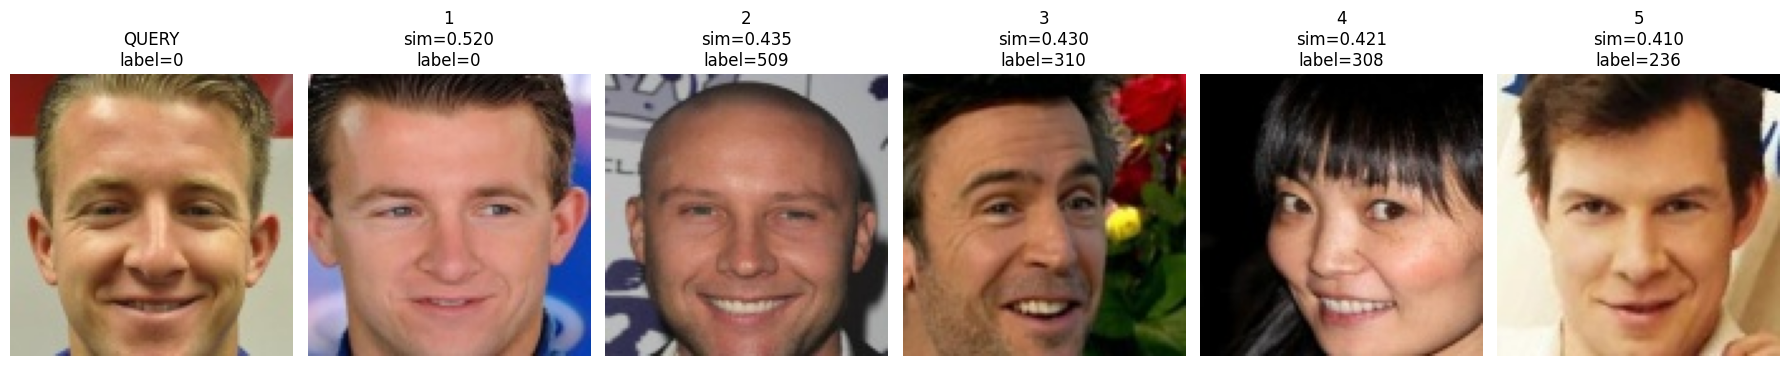

In [18]:
show_ranking_images(
    df_test,
    query_idx=q_idx,
    gallery_idx=gallery_idx,
    embs=test_embs,
    k=5
)


Первые два фото - один и тот же человек, same ≈ 0.52

diff ≈ 0.41–0.43. Что там делает азиатская девушка, я не знаю.

In [19]:
results_table = pd.DataFrame({
    "Metric": [
        "Verification Accuracy (TEST)",
        "ROC-AUC (TEST)",
        "TAR@FAR=1e-2 (TEST)",
        "TAR@FAR=1e-3 (TEST)",
        "Closed-set Accuracy@1 (TEST)",
        "Identification Rate@1 (full gallery)",
        "Identification Rate@5 (full gallery)",
        "Identification Rate@10 (full gallery)"
    ],
    "ArcFace": [
        round(test_acc, 4),
        round(test_auc, 4),
        round(tar_at_far(test_scores, ty, 1e-2), 4),
        round(tar_at_far(test_scores, ty, 1e-3), 4),
        0.7871,
        0.4134,
        0.5908,
        0.6638
    ],
    "CE Baseline": [
        "—",
        "—",
        "—",
        "—",
        round(ce_acc, 4),
        "—",
        "—",
        "—"
    ]
})



In [20]:
display(results_table.style.set_properties(**{'text-align': 'center'}))


,Metric,ArcFace,CE Baseline
0,Verification Accuracy (TEST),0.867800,—
1,ROC-AUC (TEST),0.941700,—
2,TAR@FAR=1e-2 (TEST),0.609700,—
3,TAR@FAR=1e-3 (TEST),0.432300,—
4,Closed-set Accuracy@1 (TEST),0.787100,0.671900
5,Identification Rate@1 (full gallery),0.413400,—
6,Identification Rate@5 (full gallery),0.590800,—
7,Identification Rate@10 (full gallery),0.663800,—


Сравнение показало, что модель, обученная с использованием ArcFace loss, значительно превосходит baseline на Cross-Entropy.

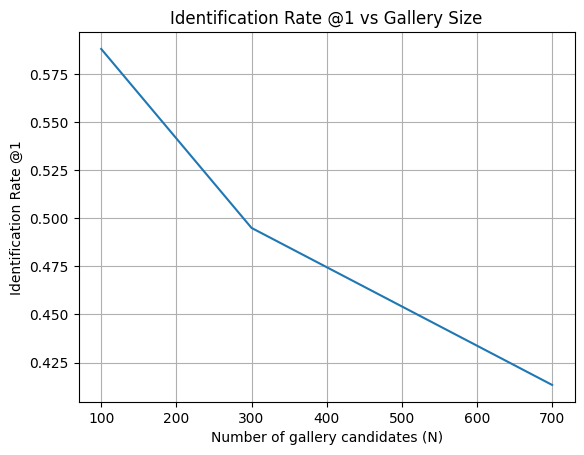

In [21]:

Ns = [100, 300, len(gallery_idx)]
IRs = [
    0.5880,   # N=100
    0.4950,   # N=300
    0.4134    # full gallery
]

plt.figure()
plt.plot(Ns, IRs)
plt.xlabel("Number of gallery candidates (N)")
plt.ylabel("Identification Rate @1")
plt.title("Identification Rate @1 vs Gallery Size")
plt.grid(True)
plt.show()


Кривая монотонно убывающая, без резких скачков, без нестабильности.
Поведение логичное, чем больше distractors, тем сложнее найти правильное совпадение.
Нет хаотических скачков, если бы alignment или embedding были нестабильны, график был бы неровным.

**Вывод:** В работе реализован и протестирован не полный пайплайн распознавания лиц (без детектирования, обрезания, выравнивания изображений) до оценки в режимах верификации (1:1) и идентификации (1:N).

Модель с ArcFace loss продемонстрировала высокое качество разделения эмбеддингов (ROC-AUC ≈ 0.94, Verification Accuracy ≈ 0.87) и существенно превзошла baseline на Cross-Entropy.